In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import simpson
from scipy.interpolate import interp1d
from scipy.stats import skew
from scipy.signal import find_peaks

In [28]:
#This function is used to remove the NAN values from the luma dataset generated by camera
def remove_nan(Data_L, Data_T):
    # Remove or interpolate NaN values in raw luma data
    if np.isnan(Data_L).any():
        print("NaN values found in raw luma data. Interpolating...")
        valid_indices = np.where(~np.isnan(Data_L))[0]  # Indices of non-NaN values
        interpolator = interp1d(Data_T[valid_indices], Data_L[valid_indices], kind='linear', fill_value="extrapolate")
        Data_L = interpolator(Data_T)  # Interpolate to fill NaN values
    return Data_L

# This function is used to invert the orignal luma data which is generated by the camera    
def luma_in(Data_L):
    return np.max(Data_L) - Data_L# Invert the data

# This function is to filter the raw luma dataset to make it easy to analyze
def luma_filter(Data_L, W_L):
    polyorder = 2
    return savgol_filter(Data_L, W_L, polyorder)

# This function gives the RTD curve, Residence time and the variance by taking in the luma and the time data
def E_T_curve(Data_L, Data_T):
    # Subtract the baseline (initial luma value) to ensure the curve starts from zero
    baseline = Data_L[0]
    Data_L = Data_L - baseline

    # Normalize the smoothed luma data to get E(t)
    area = simpson(Data_L, Data_T)  # Calculate the area under the curve
    E_t = Data_L / area         # Normalize to get E(t)
    
    # Calculate the mean residence time (τ)
    mean_residence_time = simpson(Data_T * E_t, Data_T)  # Integrate t * E(t) over time
    
    # Calculate the variance of the RTD (σ²)
    variance = simpson((Data_T - mean_residence_time)**2 * E_t, Data_T)  # Integrate (t - τ)² * E(t) over time


    # Plot the E(t) curve
    plt.figure(figsize=(10, 6))
    plt.plot(Data_T, E_t, label='E(t) Curve', color='green', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('E(t)')
    plt.title('Residence Time Distribution (RTD) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return E_t, mean_residence_time, variance

# This function gives out the dispersion number and the Dispersion coeffecient (D) of the Reactor for the given conditions
def Dispersion(velocity, length, M_R_T, Var):
    # Given parameters
    L = length  # Length of the reactor (m) - Replace with your reactor length
    u = velocity  # Superficial velocity (m/s) - Replace with your superficial velocity

    # Calculate the dispersion number (D/uL)
    dispersion_number = Var / (2 * M_R_T**2)

    # Calculate the axial dispersion coefficient (D)
    D = dispersion_number * u * L
    
    return dispersion_number, D

In [29]:
# This is the actual function that gives the Mean Residence time and the Variance value.
def analyze_rtd(time, luma):
    # Ensure the data is a numpy array
    time = np.array(time)
    luma = np.array(luma)

    # Compute integrals using the trapezoidal rule
    integral_C = np.trapz(luma, time)  # ∫ C(t) dt
    integral_tC = np.trapz(time * luma, time)  # ∫ t * C(t) dt
    integral_t2C = np.trapz(time**2 * luma, time)  # ∫ t^2 * C(t) dt

    # Compute mean residence time (MRT)
    tau = integral_tC / integral_C

    # Compute variance
    variance = (integral_t2C / integral_C) - tau**2

    return tau, variance

In [30]:
# This array filters/snipps the Time and the Luma array only at the end of the array
def filter_arrays_by_time(time, luma_RA, time_threshold):
    mask = time <= time_threshold  # Boolean mask for values within the threshold
    return time[mask], luma_RA[mask]

In [31]:
# This array filters/Snipps the Time and Luma array according to the defined start and the end time values
def filter_arrays_by_time_start(time, luma_RA, time_threshold, start_time=None):
    # Create a mask for the end threshold
    mask = time <= time_threshold

    # Apply the start threshold if provided
    if start_time is not None:
        mask = mask & (time >= start_time)  # Combine with the start threshold

    # Return the filtered arrays
    return time[mask], luma_RA[mask]

In [6]:
# Function to conver RPM into flowrate
def pump_flow(RPM):
    flow = (0.0003*RPM*RPM) + (0.1921*RPM) + 0.1242
    return flow*1e-6 # makes flow rate in m3/s

In [7]:
# Function to calculate the Dispersion number, Dispersion coeffecient and the peclet Number for the reactor
def reactor_dispersion(variance, mean_RT, Len, In_rad, REV_MIN):
    flow_rt = pump_flow(REV_MIN)
    flow_vel = flow_rt/(np.pi*In_rad*In_rad) #flow velocity in m/s
    # Calculate the dispersion number (D/uL)
    dispersion_number = variance / (2 * mean_RT**2)

    # Calculate the axial dispersion coefficient (D)
    D = dispersion_number * flow_vel * Len
    
    # Calculating Peclet Number
    pe = 1/dispersion_number
    return D, dispersion_number, pe

In [8]:
def Dean_number(In_rad, alpha, REV_MIN):
    flow_rt = pump_flow(REV_MIN)
    flow_vel = flow_rt/(np.pi*In_rad*In_rad) #flow velocity in m/s
    # Calculating the Reynolds Number
    Re = ((In_rad*2)*flow_vel)/1e-6 # Assuming the Kinematic Viscosity of water at 20 C
    
    # Calculating the Dean Number
    De = Re*np.sqrt(alpha)
    return De, Re, flow_vel

Reactor Input Section

In [9]:
# REACTOR SPECIFICATIONS / REACTOR INPUTS
L = 14  # The total length of the reactor in m
ID = 6 # Internal Diameter in mm
IR = (ID/2)*0.001  # Internal Radius of tube in m
Coil_dia = 120 # Coil Dia in´mm
lamda = Coil_dia/ID
RPM = 14 # Pump RPM 

In [10]:
# Load the CSV file
file_path_RT_RTD_R1 = '23_rpm_RGB_Luma_data_RT_RTD_R1_blau_2ml_tracer.csv'  # Replace with the path to your CSV file
file_path_RT_RTD_R2 = '23_rpm_RGB_Luma_data_RT_RTD_R2_blau_2ml_tracer.csv'
file_path_RT_RTD_R3 = '23_rpm_RGB_Luma_data_RT_RTD_R3_blau_2ml_tracer.csv'

data_R1 = pd.read_csv(file_path_RT_RTD_R1)
data_R2 = pd.read_csv(file_path_RT_RTD_R2)
data_R3 = pd.read_csv(file_path_RT_RTD_R3)

# Section to Extract the 'time' and 'luma_B1RG_RA_13.66RO' columns
# Extracting the time array for different runs
time_R1 = data_R1['Time (s)']
time_R2 = data_R2['Time (s)']
time_R3 = data_R3['Time (s)']

# Extracting the Luma arrays for different runs
luma_R1 = data_R1['Luma Value']
luma_R2 = data_R2['Luma Value']
luma_R3 = data_R3['Luma Value']

In [11]:
time_data = {'R1': time_R1, 'R2': time_R2, 'R3': time_R3}
luma_data = {'R1': luma_R1, 'R2': luma_R2, 'R3': luma_R3}

'''
time_data = {'R2': time_R2, 'R4': time_R4, 'R6': time_R6}
luma_data = {'R2': luma_R2, 'R4': luma_R4, 'R6': luma_R6}
'''

"\ntime_data = {'R2': time_R2, 'R4': time_R4, 'R6': time_R6}\nluma_data = {'R2': luma_R2, 'R4': luma_R4, 'R6': luma_R6}\n"

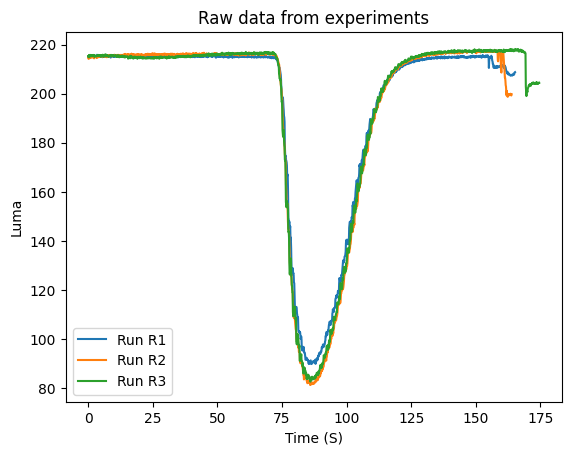

In [12]:
# Plotting
for run in time_data:
    plt.plot(time_data[run], luma_data[run], label=f'Run {run}')

plt.xlabel('Time (S)')
plt.ylabel('Luma')
plt.title('Raw data from experiments')
plt.legend()
plt.show()

In [13]:
# This inverts the luma array for better calculations
inverted_luma = {run: luma_in(luma_data[run]) for run in luma_data}
smo_luma = {}
# Apply the luma_filter function to each run to smoothen the raw luma data
for run in inverted_luma:
    smo_luma[run] = luma_filter(inverted_luma[run], 101)  # Apply filter with window size 101

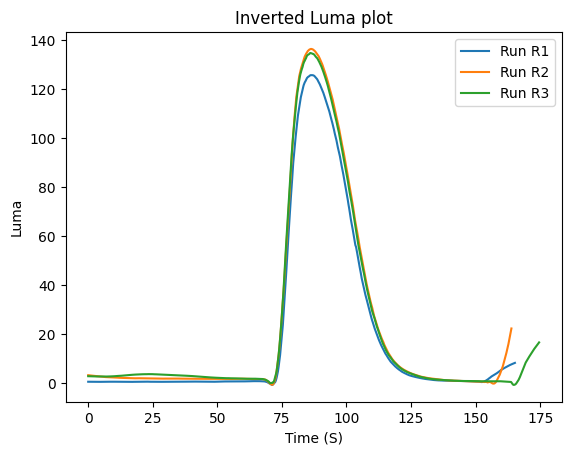

In [14]:
# Plotting the inverted and smoothened Raw luma data
for run in time_data:
    plt.plot(time_data[run], smo_luma[run], label=f'Run {run}')

plt.xlabel('Time (S)')
plt.ylabel('Luma')
plt.legend()
plt.title('Inverted Luma plot')
plt.show()

In [15]:
# In this section the arrays Time and the Luma arrays are snipped according to the requirments
filtered_time = {}
filtered_luma = {}

for run in time_data:
    filtered_time[run], filtered_luma[run] = filter_arrays_by_time_start(
        time_data[run], luma_data[run], 150, 0  # Here I am snipping thr time and the luma array at 150 sec (as the peaks after the 150 Sec are known error and not from the RTD mesurments
    )

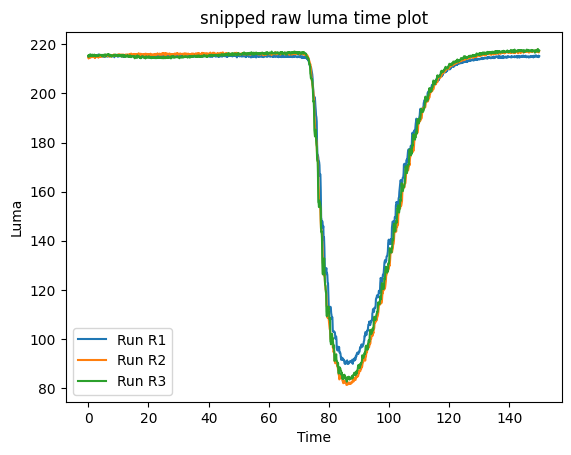

In [16]:
# Plotting the snipped Luma Time Plot
for run in filtered_time:
    plt.plot(filtered_time[run], filtered_luma[run], label=f'Run {run}')

plt.xlabel('Time')
plt.ylabel('Luma')
plt.legend()
plt.title('snipped raw luma time plot')
plt.show()

In [17]:
# Inverting and smoothening the snipped raw luma time plot
inverted_luma = {run: luma_in(filtered_luma[run]) for run in filtered_luma}
smo_luma = {}
# Apply the luma_filter function to each run
for run in inverted_luma:
    smo_luma[run] = luma_filter(inverted_luma[run], 101)  # Apply filter with window size 101

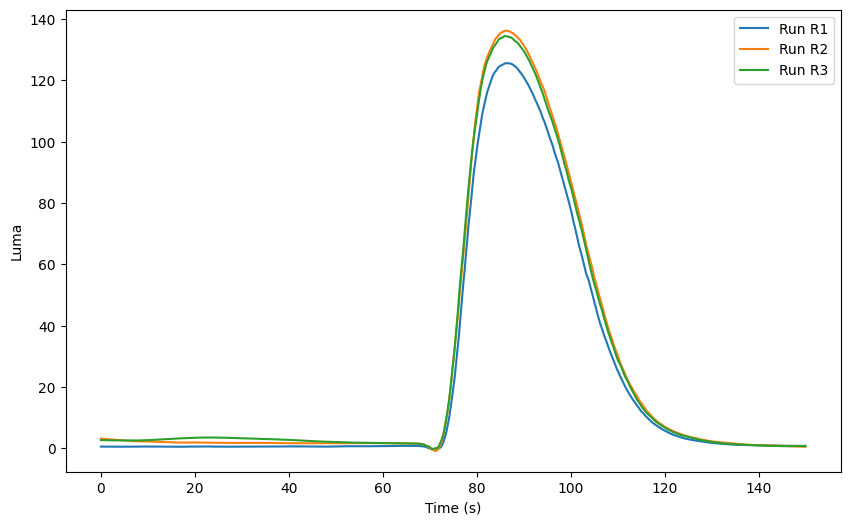

In [18]:
plt.figure(figsize=(10, 6))
for run in time_data:
    plt.plot(filtered_time[run], smo_luma[run], label=f'Run {run}')

plt.xlabel('Time (s)')
plt.ylabel('Luma')
plt.legend()
plt.show()

In [32]:
def find_main_peak_stabilization(time, luma, rate_threshold=0.09):
    """
    Returns:
    - main_peak_time: Time of the highest luma peak (None if no peak found)
    - stabilization_time: First stable time after peak (None if no stabilization)
    """
    time = np.array(time)
    luma = np.array(luma)

    # 1. Find the largest peak (with minimum height=10% of max luma)
    min_height = 0.1 * np.max(luma)  # Adjust this threshold as needed
    peaks, properties = find_peaks(luma, height=min_height)

    if len(peaks) == 0:
        return None, None

    main_peak_idx = peaks[np.argmax(properties['peak_heights'])]
    main_peak_time = time[main_peak_idx]

    # 2. Calculate derivative
    deriv = np.diff(luma) / np.diff(time)
    deriv_time = time[:-1]  # Time points for derivative

    # 3. Find first stabilization after peak
    post_peak_mask = (deriv_time > main_peak_time)
    stable_points = np.where(np.abs(deriv[post_peak_mask]) <= rate_threshold)[0]

    stabilization_time = deriv_time[post_peak_mask][stable_points[0]] if len(stable_points) > 0 else None

    return main_peak_time, stabilization_time

# Apply to all runs with safe printing
results = {}
for run in smo_luma:
    peak_time, stable_time = find_main_peak_stabilization(
        filtered_time[run],
        smo_luma[run]
    )
    results[run] = {'main_peak': peak_time, 'stabilization': stable_time}

    # Safe printing (handles None values)
    peak_str = f"{peak_time:.2f}" if peak_time is not None else "N/A"
    stable_str = f"{stable_time:.2f}" if stable_time is not None else "N/A"
    print(f"Run {run}: Main peak at {peak_str}, stabilized at {stable_str}")

Run R1: Main peak at 86.61, stabilized at 86.84
Run R2: Main peak at 86.34, stabilized at 132.46
Run R3: Main peak at 85.99, stabilized at 86.90


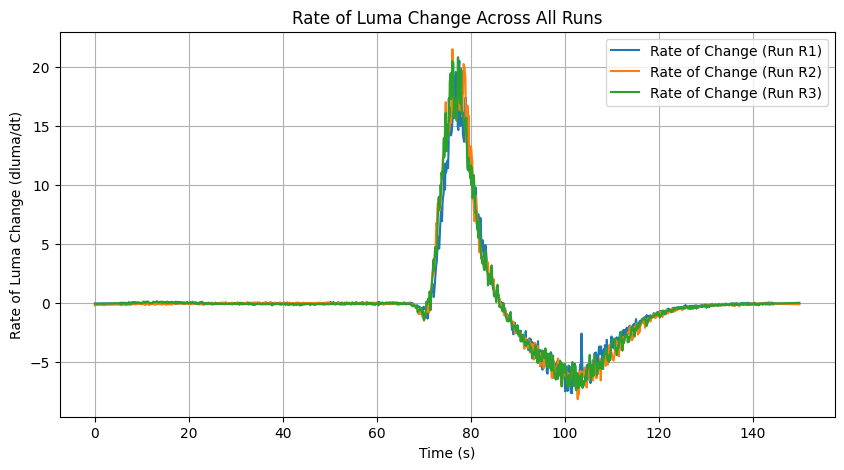

In [34]:
plt.figure(figsize=(10, 5))

for run in ['R1', 'R2', 'R3']:
    # Calculate derivative (dluma/dt)
    time = np.array(filtered_time[run])
    luma = np.array(smo_luma[run])
    deriv = np.diff(luma) / np.diff(time)
    deriv_time = (time[:-1] + time[1:]) / 2  # Midpoints for plotting

    # Plot the rate of change
    plt.plot(deriv_time, deriv, label=f'Rate of Change (Run {run})')

plt.xlabel('Time (s)')
plt.ylabel('Rate of Luma Change (dluma/dt)')
plt.title('Rate of Luma Change Across All Runs')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Compute skewness to understand the spredding of the RTD curve
skewness_results = {
    run: {
        'time_skewness': skew(filtered_time[run]),
        'luma_skewness': skew(smo_luma[run])
    }
    for run in filtered_luma
}

# Print results
for run, result in skewness_results.items():
    print(
        f"Run {run}: "
        f"Time Skewness = {result['time_skewness']:.3f}, "
        f"Luma Skewness = {result['luma_skewness']:.3f}"
    )

# Calculate skewness for all runs
luma_skewness_values = [skew(luma) for luma in smo_luma.values()]

# Compute average and standard deviation
avg_skew = np.mean(luma_skewness_values)
std_skew = np.std(luma_skewness_values, ddof=1)  # ddof=1 for sample standard deviation

print(f"Average luma skewness: {avg_skew:.3f} ± {std_skew:.3f}")

Run R1: Time Skewness = -0.007, Luma Skewness = 1.724
Run R2: Time Skewness = 0.021, Luma Skewness = 1.681
Run R3: Time Skewness = -0.016, Luma Skewness = 1.633
Average luma skewness: 1.679 ± 0.046


In [22]:
tau_results = {}
sigma2_results = {}

# Apply the analyze_rtd function to each run
for run in filtered_time:
    tau_results[run], sigma2_results[run] = analyze_rtd(
        filtered_time[run], smo_luma[run]  # Analyze data for each run
    )

C:\Users\hardi\AppData\Local\Temp\ipykernel_8392\4201490843.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_C = np.trapz(luma, time)  # ∫ C(t) dt
C:\Users\hardi\AppData\Local\Temp\ipykernel_8392\4201490843.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_tC = np.trapz(time * luma, time)  # ∫ t * C(t) dt
C:\Users\hardi\AppData\Local\Temp\ipykernel_8392\4201490843.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_t2C = np.trapz(time**2 * luma, time)  # ∫ t^2 * C(t) dt


In [23]:
tau_arr = []
sigma_arr = []
for run in tau_results:
    tau_arr.append(tau_results[run])
    sigma_arr.append(sigma2_results[run])

average_tau = np.mean(tau_arr)
STD_tau = np.std(tau_arr, ddof=0)
average_variance = np.mean(sigma_arr)
STD_variance = np.std(sigma_arr, ddof=0)

In [24]:
print('Average Mean Residence Time: ', round(average_tau, 2))
print('Standard Deviation (Mean Residence Time): ', round(STD_tau, 2), '%')
print('Average variance: ', round(average_variance, 2))
print('Standard Deviation (Variance): ', round(STD_variance, 2), '%')

Average Mean Residence Time:  90.37
Standard Deviation (Mean Residence Time):  0.93 %
Average variance:  237.39
Standard Deviation (Variance):  59.03 %


In [25]:
Dispersion_coff, dispersion_number, pe_nu = reactor_dispersion(average_variance, average_tau, L, IR, 5.7381999999999995e-06)

Reactor Output section

In [26]:
D_e, R_e, f_v = Dean_number(IR, lamda, 5.7381999999999995e-06)
#PUMP_FLOW_RATE_M3_SEC = pump_flow(RPM)
print('Dean Number (De): ', round(D_e, 3))
print('Reynolds Number (Re): ', round(R_e, 3))
print('Peclet Number (Pe): ', round(pe_nu, 3))
print('Dispersion Number: ', round(dispersion_number, 3))
print('Axial Dispersion Coeffecients (De_ax): ', round(Dispersion_coff, 3))
print('Superficial fluid Velocity (U): ', round(f_v, 3), ' m/s')


Dean Number (De):  117.869
Reynolds Number (Re):  26.356
Peclet Number (Pe):  68.809
Dispersion Number:  0.015
Axial Dispersion Coeffecients (De_ax):  0.001
Superficial fluid Velocity (U):  0.004  m/s
